In [1]:
conda install quandl

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
path = r'/Users/andrenedvidek/Desktop/Data Analaysis/CareerFoundry /Data Emersion /Task 6.1/02 Data/Original Data'

In [4]:
zillow_data = pd.read_csv(os.path.join(path, 'ZILLOW-DATA.csv'))

In [5]:
zillow_data.shape

(10000, 4)

In [6]:
zillow_data.head(5)


,indicator_id,region_id,date,value
0,ZSFH,99999,2024-06-30,481540.769792
1,ZSFH,99999,2024-05-31,480258.243144
2,ZSFH,99999,2024-04-30,477462.034343
3,ZSFH,99999,2024-03-31,476120.204987
4,ZSFH,99999,2024-02-29,476598.175844


In [7]:
type(zillow_data)

pandas.core.frame.DataFrame

In [8]:
print(zillow_data.dtypes)

indicator_id     object
region_id         int64
date             object
value           float64
dtype: object


In [9]:
# Ensure the date column is of datetime type
zillow_data['date'] = pd.to_datetime(zillow_data['date'])


In [10]:
zillow_data.sort_values(by='date', inplace=True)

In [11]:
print(zillow_data.isnull().sum())

indicator_id    0
region_id       0
date            0
value           0
dtype: int64


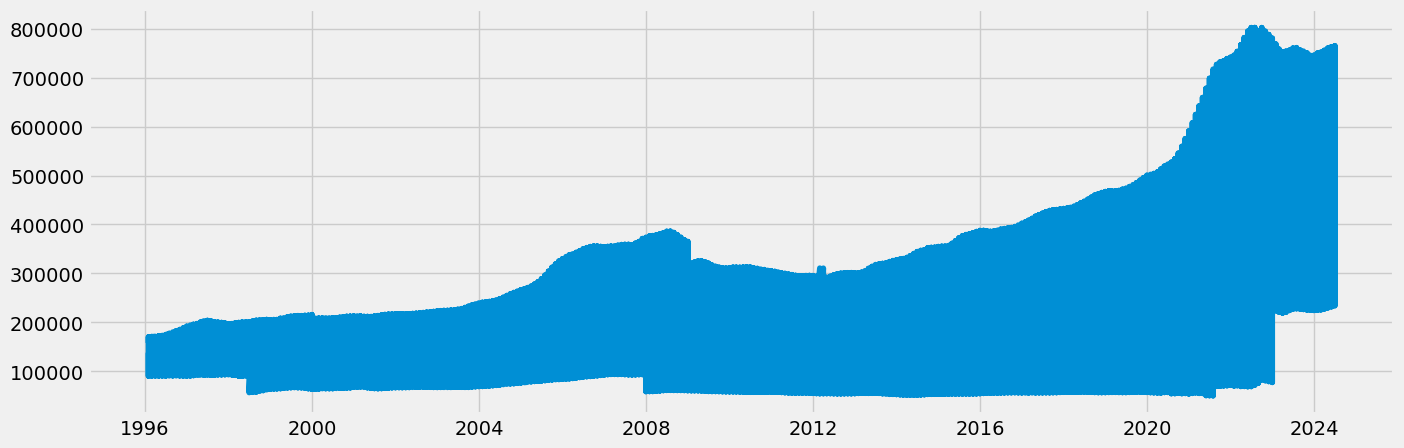

In [12]:
# Plotting the data
plt.figure(figsize=(15, 5), dpi=100)


plt.plot(zillow_data['date'], zillow_data['value'], label='Value')

plt.show()

#### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

data = zillow_data.reset_index()

In [14]:
data.head()

,index,indicator_id,region_id,date,value
0,9193,ZSFH,99962,1996-01-31,157893.0
1,8509,ZSFH,99964,1996-01-31,169804.0
2,9535,ZSFH,99961,1996-01-31,128795.0
3,8167,ZSFH,99965,1996-01-31,169960.0
4,9877,ZSFH,99960,1996-01-31,155728.0


In [15]:
columns_to_drop = ['indicator_id', 'region_id','index']
data_2 = data.drop(columns=columns_to_drop)


In [16]:
data_2.head()

,date,value
0,1996-01-31,157893.0
1,1996-01-31,169804.0
2,1996-01-31,128795.0
3,1996-01-31,169960.0
4,1996-01-31,155728.0


In [17]:
data_sub = data_2.loc[(data_2['date'] >= '2000-01-01') & (data_2['date'] < '2024-01-01')]

In [18]:
data_sub.shape

(9352, 2)

In [19]:
data_sub.head()

,date,value
456,2000-01-31,208289.097236
457,2000-01-31,84387.000000
458,2000-01-31,63311.000000
459,2000-01-31,188833.324112
460,2000-01-31,84170.606187


In [20]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,value
datetime,
2000-01-31,208289.097236
2000-01-31,84387.000000
2000-01-31,63311.000000
2000-01-31,188833.324112
2000-01-31,84170.606187


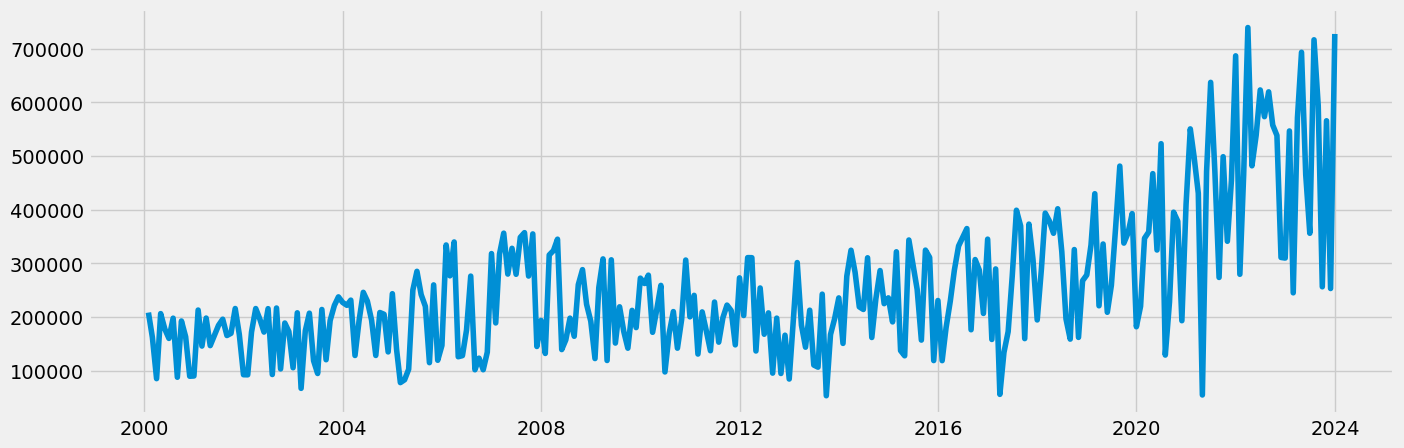

In [33]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [22]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

value    0
dtype: int64

In [23]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

data_sub = data_sub[~data_sub.index.duplicated(keep='first')]

In [24]:

dups = data_sub.duplicated()
dups.sum()


0

In [25]:
data_sub = data_sub.asfreq('M')

In [26]:
# I am using a monthly average to move forward to reduce of noise
monthly_mean = data_sub.resample('M').mean()

####  Time-series analysis: decomposition

In [27]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')

In [28]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

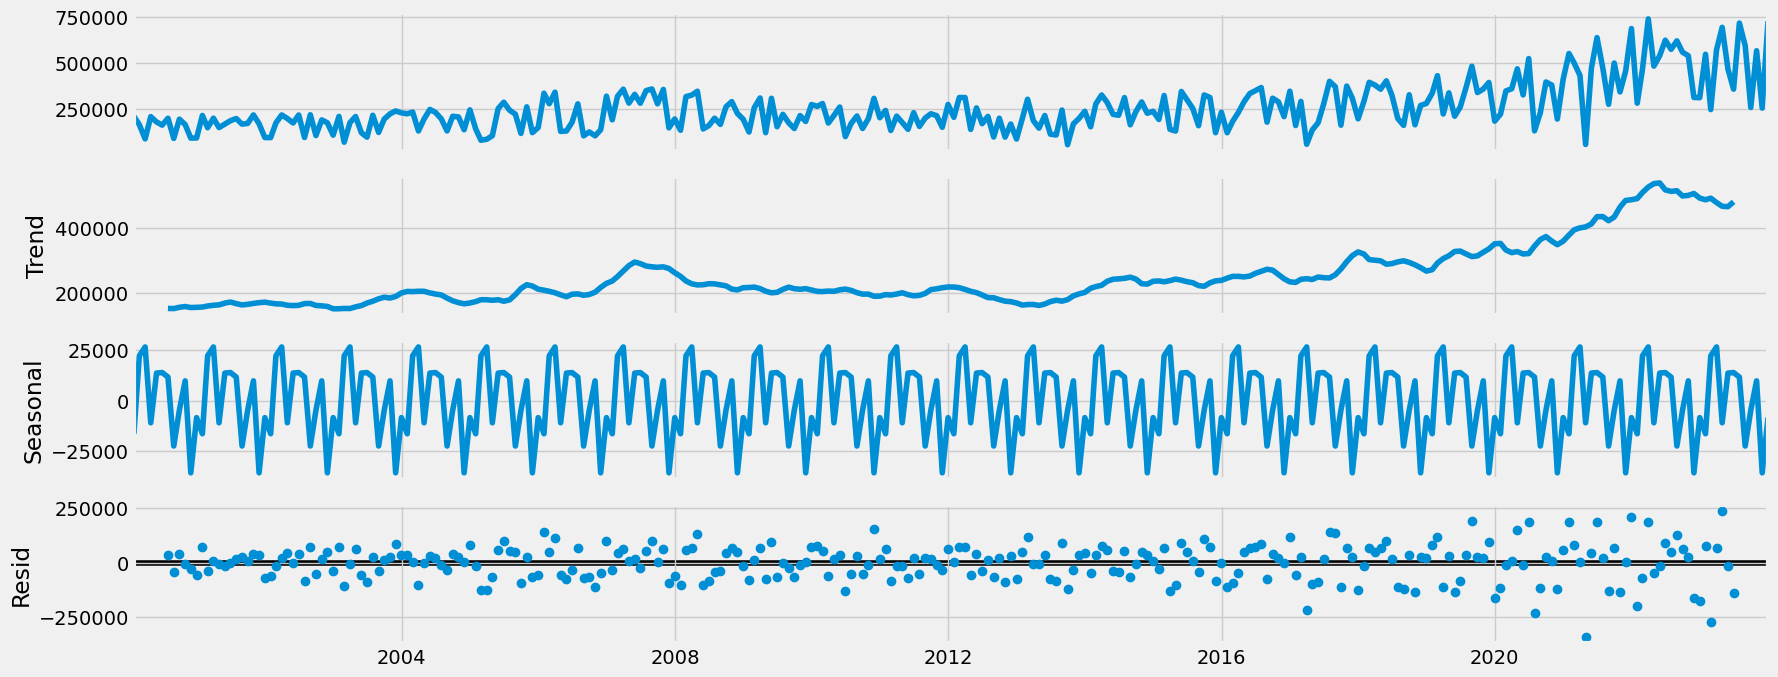

In [29]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Testing for stationarity

In [34]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_mean['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.034251
p-value                          0.955606
Number of Lags Used             13.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64


#### Observations: The Dickey-Fuller test that we conducted shows that these time series are non - stationary.
#### The Test Statistic is far smaller then the any Critical Value.  
#### In addition the p - value of 0.955606 further proves we are dealing with non - stationary data
#### Thus, we have to stay by the null- hypothesis that the data is nonstationary. This is further supported by the autocorrelation test showing an unsatisfactory result.

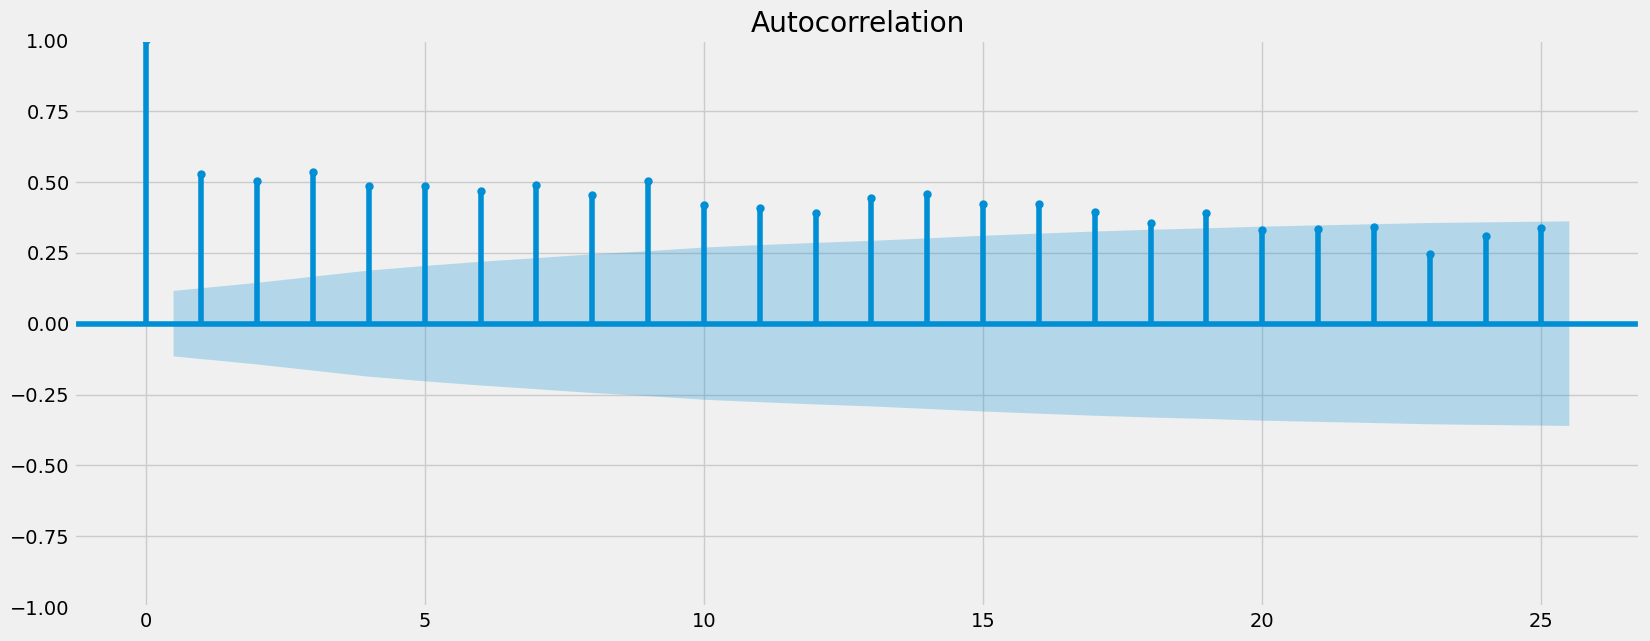

In [35]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(monthly_mean)
plt.show()

#### Stationarizing Data

In [36]:
monthly_mean_diff = monthly_mean - monthly_mean.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [37]:
monthly_mean_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [38]:
monthly_mean_diff.head()

,value
datetime,
2000-02-29,-46098.561309
2000-03-31,-77124.911267
2000-04-30,121270.053768
2000-05-31,-28963.678429
2000-06-30,-17266.264944


In [39]:
monthly_mean_diff.columns

Index(['value'], dtype='object')

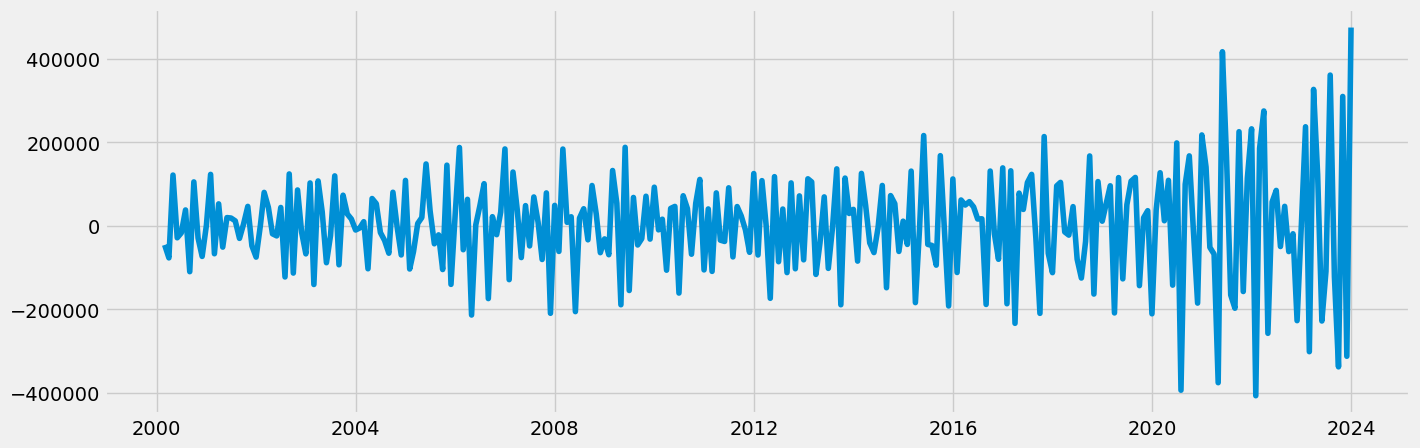

In [40]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(monthly_mean_diff)

In [41]:
dickey_fuller(monthly_mean_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.806752e+00
p-value                        7.247329e-12
Number of Lags Used            1.200000e+01
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
dtype: float64


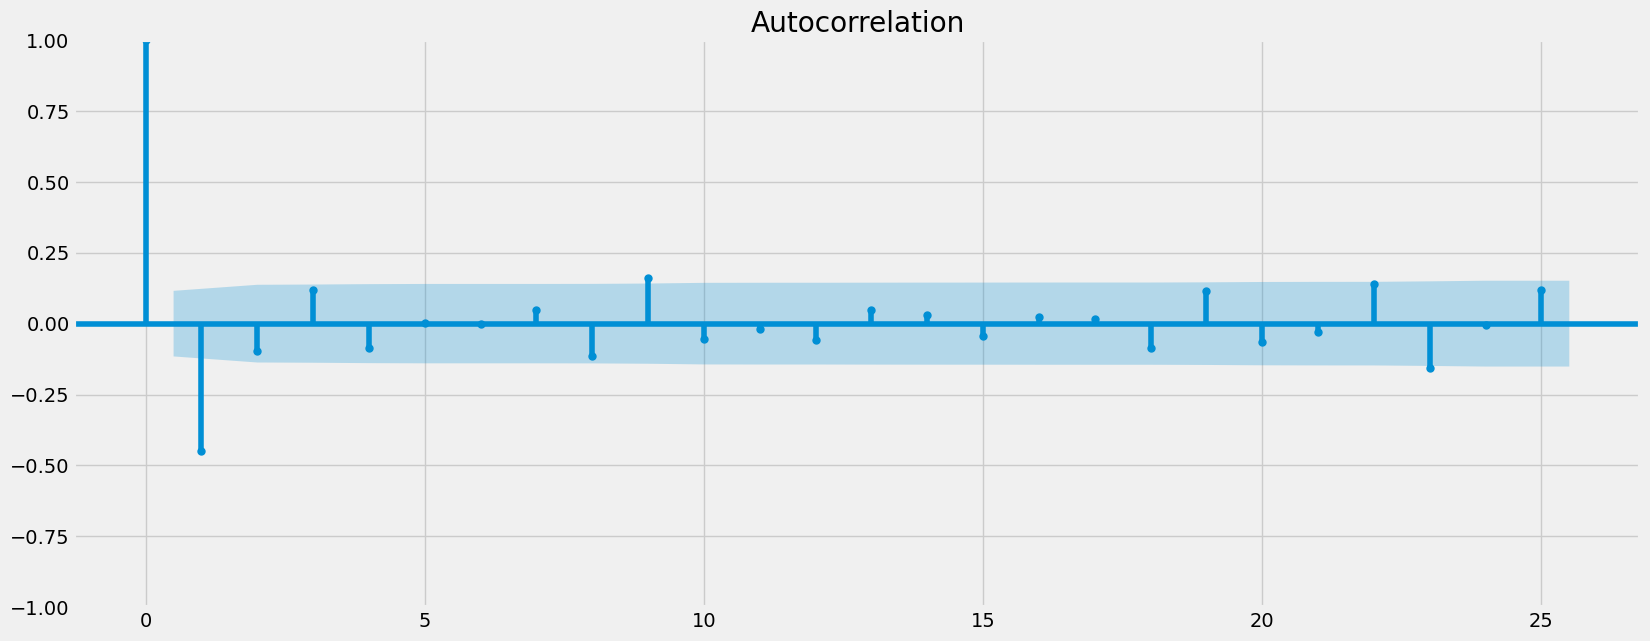

In [42]:
plot_acf(monthly_mean_diff)
plt.show()

#### After Differencing we can see by looking at the results of the Dickey-Fuller Stationarity test as well as the autocorrelation that the data we now have achieved stationary data and can now use this data for potential forecasting